## Contents

This notebook covers the basics of creating an event list object and carrying out various operations such as simulating time and energies, joining, storing and retrieving event lists.

## Setup

Import some useful libraries.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

Import some relevant stingray classes.

In [2]:
from stingray import EventList, Lightcurve

# Creating EventList from Photon Arrival Times

Given photon arrival times, an eventlist object can be created. Times are assumed to be seconds from a reference MJD, that can optionally be specified with the `mjdref` keyword and attribute.

In [3]:
times = [0.5, 1.1, 2.2, 3.7]
mjdref=58000.

Create event list object by passing arrival times as argument.

In [4]:
ev = EventList(times, mjdref=mjdref)
ev.time

array([0.5, 1.1, 2.2, 3.7])

One can add all sorts of data to the `EventList` object, it is very flexible. In general, we suggest to stick with easily interpretable attributes, like `energy` or `pi`.

```
ev.energy = [0., 3., 4., 20.]
```

is the same as 

In [5]:
energy = [0., 3., 4., 20.]
ev = EventList(times, energy=energy, mjdref=mjdref)

It is always recommended to specify the good time intervals (GTIs) of the event list, as the time intervals where the instrument was fully operational. If not specified, GTIs are defined automatically as the first and the last event time.

In [6]:
gti = [[0, 4]]
ev = EventList(times, gti=gti, energy=energy, mjdref=mjdref)

## Roundtrip to Astropy-compatible formats

`EventList` has the following methods that allow an easy roundtrip to Astropy objects: `to_astropy_table`, `to_astropy_timeseries`, `from_astropy_table`, `from_astropy_timeseries`

This allows a better interoperability with the Astropy ecosystem. 

In this roundtrip, a `Table` or `Timeseries` object is created, having as columns `time` and all other attributes of the same size (e.g. `pi`, `energy`), and the rest of the attributes (e.g. `gti`, `mjdref`) in the table's metadata.

In [7]:
table = ev.to_astropy_table()
table

energy,time
float64,float64
0.0,0.5
3.0,1.1
4.0,2.2
20.0,3.7


When converting to `Timeseries`, times are transformed into `astropy.time.TimeDelta` objects.

In [8]:
timeseries = ev.to_astropy_timeseries()
timeseries

time,energy
object,float64
5.787037037037037e-06,0.0
1.2731481481481482e-05,3.0
2.5462962962962965e-05,4.0
4.282407407407408e-05,20.0


In [9]:
table.meta

OrderedDict([('dt', 0),
             ('gti', array([[0, 4]])),
             ('mjdref', 58000.0),
             ('ncounts', 4),
             ('notes', '')])

Of course, these objects can be converted back to event lists. The user should be careful in defining the proper column names and metadata so that the final object is a valid `EventList`

In [10]:
table_ev = EventList.from_astropy_table(table)
table_ts = EventList.from_astropy_timeseries(timeseries)


In [11]:
table_ev.time, table_ts.time

(array([0.5, 1.1, 2.2, 3.7]), array([0.5, 1.1, 2.2, 3.7]))

# Loading and writing EventList objects

We made it possible to save and load data in a number of different formats.

The general syntax is

```
ev = EventList.read(filename, format)

ev.write(filename, format)

```

There are three main blocks of formats that might be useful:

1. (read-only) HEASoft-compatible formats -> read event data from HEASOFT-supported missions

2. `pickle`: reading and saving EventLists from/to Python pickle objects

3. Any format compatible with `astropy.table.Table` objects.

## Loading an EventList from an X-ray observation in HEASoft-compatible format

Loading event data from HEASoft-supported missions in FITS format is easy. It's sufficient to use the `read` method with `hea` or, equivalently, `ogip`, as format. 

Beware: please use `hea` or `ogip`, not `fits`! It would make the roundrip to Astropy tables more complicated, as Astropy supports a generic FITS writer which is not necessarily compatible with HEASoft.

In [12]:
ev = EventList.read('events.fits', 'ogip')

Times are saved to the `time` attribute, GTIs to the `gti` attribute, MJDREF to the `mjdref` attribute, etc. 

In [13]:
ev.time[:10]

array([80000000.23635569, 80000001.47479323, 80000001.78458866,
       80000002.78943624, 80000003.42859936, 80000004.07943003,
       80000006.09310323, 80000007.18041813, 80000008.17602143,
       80000008.20403489], dtype=float128)

In [14]:
ev.mjdref

55197.00076601852

In [15]:
ev.gti

array([[80000000., 80001025.]], dtype=float128)

## Roundtrip to pickle objects

It is possible to save and load eventlist objects using `pickle`.

In [16]:
ev.write("events.p", "pickle")
ev2 = EventList.read("events.p", "pickle")

np.allclose(ev2.time, ev.time), np.allclose(ev2.gti, ev.gti)

(True, True)

## Roundtrip to Astropy-compatible formats

If the `read` and `write` methods receive a format which is not `hea`, `ogip`, or `pickle`, the event list is transformed into an `Astropy` `Table` object with the methods described above, and the readers and writers from the `Table` class are used instead. This allows to extend the save/load operations to a large number of formats, including `hdf5` and enhanced CSV (`ascii.ecsv`).

Note that columns coming from the `EVENTS` (or equivalent) fits extension, those having the same length as `time`, when converting to `astropy` tables they become columns of the table. All the others, including `gti`, are treated as metadata.

Care should be used in selecting formats that preserve metadata. For example, simple CSV format loses all metadata, including MJDREF, GTIs etc.

In [17]:
ev.write("events.hdf5", "hdf5")
ev3 = EventList.read("events.hdf5", "hdf5")
ev3.time[:10]

array([80000000.23635569, 80000001.47479323, 80000001.78458866,
       80000002.78943624, 80000003.42859936, 80000004.07943003,
       80000006.09310323, 80000007.18041813, 80000008.17602143,
       80000008.20403489], dtype=float128)

In [18]:
# Try the round trip again to verify that everything works

ev.write("events.ecsv", "ascii.ecsv")
ev4 = EventList.read("events.ecsv", "ascii.ecsv")
!cat events.ecsv
ev4.time[:10]

# %ECSV 1.0
# ---
# datatype:
# - {name: energy, datatype: float32}
# - {name: pi, datatype: float32}
# - {name: time, datatype: float128}
# meta: !!omap
# - {dt: 0}
# - gti: !numpy.ndarray
#     buffer: !!binary |
#       QUFBQUFBQ0FscGdaUURHRnBuOEFBQUFBQUFBZ0FKZVlHVUF4aGFaL0FBQT0=
#     dtype: float128
#     order: C
#     shape: !!python/tuple [1, 2]
# - {header: 'XTENSION= ''BINTABLE''           / binary table extension                         BITPIX  =                    8 / array
#     data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   12
#     / length of dimension 1                          NAXIS2  =                 1000 / length of dimension 2                          PCOUNT  =                    0
#     / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS
#     =                    2 / number of t

array([80000000.23635569, 80000001.47479323, 80000001.78458866,
       80000002.78943624, 80000003.42859936, 80000004.07943003,
       80000006.09310323, 80000007.18041813, 80000008.17602143,
       80000008.20403489], dtype=float128)

# Transforming a Lightcurve into an EventList.

Event lists can be obtained from light curves, where the standard followed is as follows: as many events are created as the counts in the lightcurve at the time specified by time bins.

To demonstrate this, let us define a light curve.

In [19]:
times = np.arange(3)
counts = np.floor(np.random.rand(3)*5)
lc = Lightcurve(times, counts, skip_checks=True, dt=1.)

In [20]:
lc.time, lc.counts

(array([0, 1, 2]), array([1., 4., 3.]))

Now, eventlist can be loaded by calling static `from_lc()` method.

In [21]:
ev = EventList.from_lc(lc)
ev.time

array([0, 1, 1, 1, 1, 2, 2, 2])

# Simulating EventList from Lightcurve

An arguably better way is having proper random events, reproducing the initial light curve within the errors. Stingray does this by using the inverse CDF method, using the light curve as a binned probability distribution.
Please note that in this case we will have to create the EventList object before (in technical terms, `simulate_times` is not a static method.). See simulation tutorial for more details.


In [22]:
ev = EventList()
ev.simulate_times(lc)
ev.time

array([0.60459939, 0.8644437 , 1.47100837, 1.54281243, 1.80725171,
       2.47032653])

# Creating a light curve from an EventList object

After simulating event list, the original light curve can be recovered. Let's demonstrate by creating a light curve.

In [23]:
dt = 1.
times = np.arange(50)
counts = np.floor(np.random.rand(50)*50000)
lc = Lightcurve(times, counts, skip_checks=True, dt=1.)

Simulate an event list.

In [24]:
ev = EventList()
ev = ev.from_lc(lc)

In [25]:
ev.gti

array([[-0.5, 49.5]])

Recover original light curve curve using `to_lc()` method. Here, `dt` defines time resolution, `tstart` the starting time, and `tseg` the total time duration.

In [26]:
lc_new = ev.to_lc(dt=1)

Let us verify that this has worked properly, by comparing the input and output light curves

Text(0, 0.5, 'Counts')

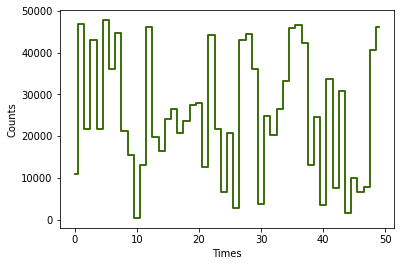

In [27]:
plt.plot(lc.time, lc.counts,'r-', lc_new.counts, 'g-', drawstyle="steps-mid")
plt.xlabel('Times')
plt.ylabel('Counts')

... and their difference

Text(0, 0.5, 'Counts')

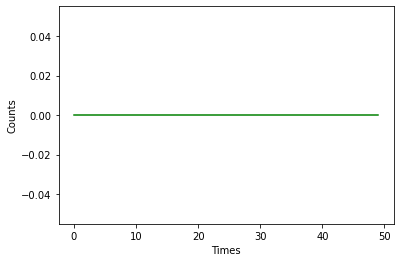

In [28]:
plt.plot(lc.time, lc.counts - lc_new.counts, 'g-', drawstyle="steps-mid")
plt.xlabel('Times')
plt.ylabel('Counts')

As can be seen from the figure above, the recovered light curve is aligned with the original light curve.

# Simulating Energies

In order to simulate photon energies, a spectral distribution needs to be passed.
The `spectrum` input is a two-dimensional array, with the energies in keV in the first dimension and the number of counts in the second. The count array will be normalized before the simulation: the raw counts do not matter, but only the ratio of the counts in each bin to the total.
Again, the energies are simulated using an inverse CDF method.

In [29]:
spectrum = [[1, 2, 3, 4, 5, 6],[1000, 2040, 1000, 3000, 4020, 2070]]

In [30]:
ev = EventList(time=np.sort(np.random.uniform(0, 1000, 12)))
ev.simulate_energies(spectrum)

In [31]:
ev.energy

array([4.84164641, 3.62741142, 3.68169619, 4.70867585, 4.92065534,
       4.93644725, 2.26749277, 5.45959615, 3.01137686, 4.86366818,
       0.63048041, 6.26300006])

# Joining EventLists

Two event lists can also be joined together. If the GTI do not overlap, the event times and GTIs are appended. Otherwise, the GTIs are crossed (i.e., only the overlapping parts are saved) and the events merged together.

In [32]:
ev1 = EventList(time=[1,2,3], gti=[[0.5, 3.5]])
ev2 = EventList(time=[4,5], gti=[[3.5, 5.5]])
ev = ev1.join(ev2)
ev.time, ev.gti

(array([1, 2, 3, 4, 5]), array([[0.5, 5.5]]))

In [33]:
ev1 = EventList(time=[1,2,3], gti=[[0.5, 3.5]])
ev2 = EventList(time=[1.2, 3.3, 5.6], gti=[[0.6, 7.8]])
ev = ev1.join(ev2)
ev.time, ev.gti

(array([1. , 1.2, 2. , 3. , 3.3, 5.6]), array([[0.6, 3.5]]))